In [1]:
from typing import List, Optional
import numpy as np

from darts import TimeSeries
from darts.models.forecasting.regression_model import (
    FUTURE_LAGS_TYPE,
    LAGS_TYPE,
    RegressionModel,
    _LikelihoodMixin,
)


class GPRegressor(RegressionModel, _LikelihoodMixin):
    def __init__(
        self,
        lags: Optional[LAGS_TYPE] = None,
        lags_past_covariates: Optional[LAGS_TYPE] = None,
        lags_future_covariates: Optional[FUTURE_LAGS_TYPE] = None,
        output_chunk_length: int = 1,
        output_chunk_shift: int = 0,
        add_encoders: Optional[dict] = None,
        random_state: Optional[int] = None,
        multi_models: Optional[bool] = True,
        use_static_covariates: bool = True,
        **kwargs,
    ):
        self.kwargs = kwargs

        # gaussian process can use parts of our pre-defined `"gaussian"` / `"normal"` likelihood
        self._likelihood = "gaussian"

        # parse likelihood
        self._rng = np.random.default_rng(seed=random_state)

        super().__init__(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            lags_future_covariates=lags_future_covariates,
            output_chunk_length=output_chunk_length,
            output_chunk_shift=output_chunk_shift,
            add_encoders=add_encoders,
            model=GaussianProcessRegressor(**kwargs),
            multi_models=multi_models,
            use_static_covariates=use_static_covariates,
        )

    # defines logic how to predict assuming the normal / gaussian likelihood
    # (all copy-pasted, only parts withing ===> START / END of adapted code <=== is new
    def _predict_normal(
        self,
        x: np.ndarray,
        num_samples: int,
        predict_likelihood_parameters: bool,
        **kwargs,
    ) -> np.ndarray:
        k = x.shape[0]

        # ====> START OF ADAPTED CODE <====
        # here we add `return_std` to `predict()` to return the standard deviation

        # model_output shape:
        # if univariate & output_chunk_length = 1: (num_samples, 2)
        # else: (2, num_samples, n_components * output_chunk_length)
        # where the axis with 2 dims is mu, sigma
        model_output = self.model.predict(x, return_std=True, **kwargs)
        model_output = np.concatenate([
            np.expand_dims(model_output[0], 0),
            np.expand_dims(model_output[1], 0)
        ], axis=0)
        output_dim = len(model_output.shape)
        if output_dim == 2:
            model_output = model_output.T
        # ====> END OF ADAPTED CODE <====

        # deterministic case: we return the mean only
        if num_samples == 1 and not predict_likelihood_parameters:
            # univariate & single-chunk output
            if output_dim <= 2:
                output_slice = model_output[:, 0]
            else:
                output_slice = model_output[0, :, :]
            return output_slice.reshape(k, self.pred_dim, -1)

        # probabilistic case
        # univariate & single-chunk output
        if output_dim <= 2:
            # embedding well shaped 2D output into 3D
            model_output = np.expand_dims(model_output, axis=0)

        else:
            # we transpose to get mu, sigma couples on last axis
            # shape becomes: (n_components * output_chunk_length, num_samples, 2)
            model_output = model_output.transpose()

        # shape (n_components * output_chunk_length, num_samples, 2)
        return model_output

    # use pre-defined `normal/gaussian` likelihood for sampling / parameters
    def _predict_and_sample(
        self,
        x: np.ndarray,
        num_samples: int,
        predict_likelihood_parameters: bool,
        **kwargs,
    ) -> np.ndarray:
        return self._predict_and_sample_likelihood(
            x, num_samples, "normal", predict_likelihood_parameters, **kwargs
        )

    # get parameters in case of `predict_likelihood_parameters=True`
    def _params_normal(self, model_output: np.ndarray) -> np.ndarray:
        """[mu, sigma] on the last dimension, grouped by component"""
        n_samples = model_output.shape[1]
        # (n_components * output_chunk_length, num_samples, 2) -> (num_samples, n_components * output_chunk_length, 2)
        params_transposed = np.swapaxes(model_output, 0, 1)
        # (num_samples, n_components * output_chunk_length, 2) -> (num_samples, output_chunk_length, n_components * 2)
        return params_transposed.reshape(n_samples, self.pred_dim, -1)

    # required to add probabilistic support
    @property
    def supports_probabilistic_prediction(self) -> bool:
        return True

    # add the component names for direct parameter predictions
    def _likelihood_components_names(
            self, input_series: TimeSeries
    ) -> Optional[List[str]]:
        """Override of RegressionModel's method to support the gaussian/normal likelihood"""
        return self._likelihood_generate_components_names(
            input_series, ["mu", "sigma"]
        )

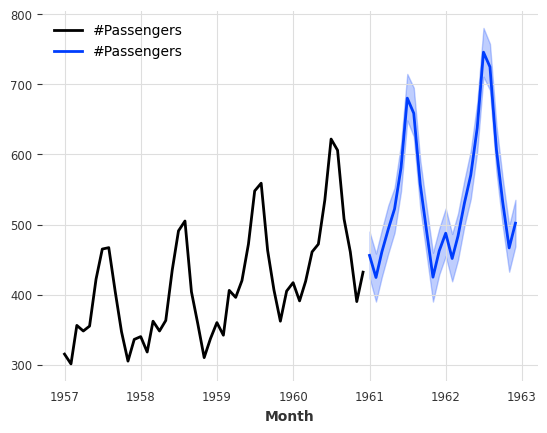

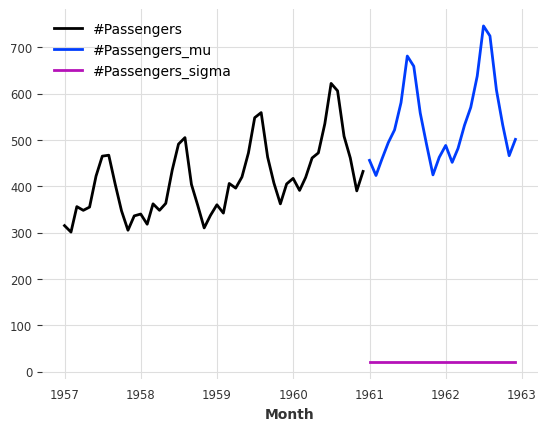

In [5]:
import matplotlib.pyplot as plt
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


series = AirPassengersDataset().load()

# define a Darts GPRegressor that uses a kernel
kernel = DotProduct() + WhiteKernel()

model = GPRegressor(
    lags=12,
    output_chunk_length=24,
    kernel=kernel  # GaussianProcessRegressor params
)
model.fit(series)

# forecasting example with sampling
preds = model.predict(n=24, num_samples=1000)

series[-48:].plot()
preds.plot()
plt.show()

# forecasting example with direct parameter (mu, sigma) prediction
preds = model.predict(n=24, num_samples=1, predict_likelihood_parameters=True)
series[-48:].plot()
preds.plot()
plt.show()

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


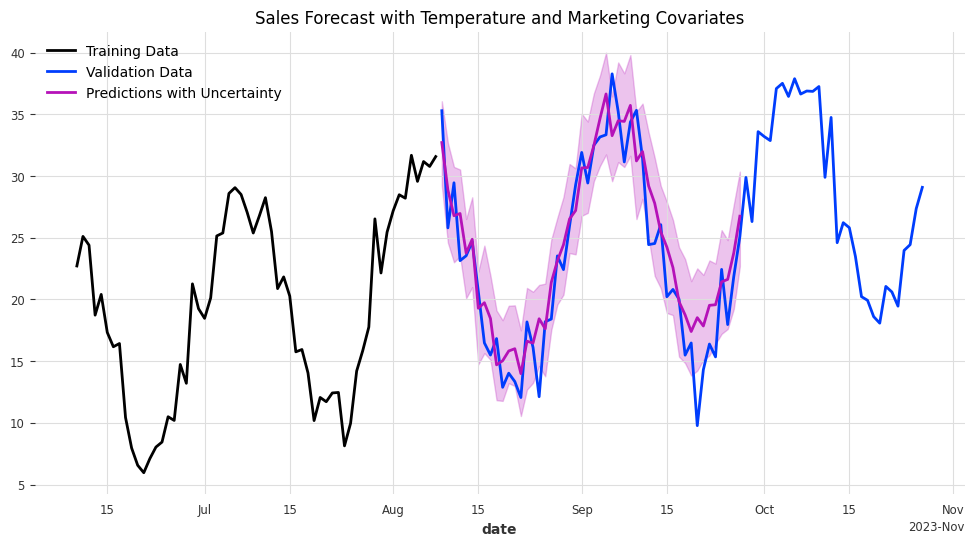

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from darts import TimeSeries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Generate sample data
np.random.seed(42)

# Create dates for 300 days
dates = [datetime(2023, 1, 1) + timedelta(days=x) for x in range(300)]

# Generate target variable (e.g., sales) with seasonality and trend
t = np.arange(300)
seasonality = 10 * np.sin(2 * np.pi * t / 30)  # 30-day seasonality
trend = 0.1 * t
noise = np.random.normal(0, 2, 300)
target = trend + seasonality + noise

# Generate two exogenous variables
temp = 20 + 10 * np.sin(2 * np.pi * t / 30) + np.random.normal(0, 2, 300)
marketing = 100 + np.random.normal(0, 10, 300)
marketing[::30] += 50  # Monthly marketing campaigns

# Create DataFrames
target_df = pd.DataFrame({
    'date': dates,
    'value': target
})
covariates_df = pd.DataFrame({
    'date': dates,
    'temperature': temp,
    'marketing': marketing
})

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(target_df, 'date', 'value')
covariates = TimeSeries.from_dataframe(covariates_df, 'date', ['temperature', 'marketing'])

# Split data properly to ensure enough coverage for covariates
split_point = -80

# Training data
train_series = series[:split_point]
train_covariates = covariates  # Use all covariates

# Validation data (just for plotting)
val_series = series[split_point:]

# Define kernel for GP
kernel = DotProduct() + WhiteKernel()

# Create and train model with covariates
# Increased output_chunk_length to match our desired prediction horizon
model = GPRegressor(
    lags=12,                    # Use last 12 values of target
    lags_past_covariates=12,    # Use last 12 values of covariates
    output_chunk_length=30,     # Increased to match prediction horizon
    kernel=kernel
)

# Fit the model
model.fit(
    train_series,
    past_covariates=train_covariates
)

# Generate predictions with uncertainty
pred_series = model.predict(
    n=50,                      # Predict 30 steps ahead
    num_samples=100,           # Generate 100 samples for uncertainty
    past_covariates=covariates # Use all covariates for prediction
)

# Plot results
plt.figure(figsize=(12, 6))
train_series[-60:].plot(label='Training Data')
val_series.plot(label='Validation Data')
pred_series.plot(label='Predictions with Uncertainty')
plt.title('Sales Forecast with Temperature and Marketing Covariates')
plt.legend()
plt.show()
